In [1]:
#importing required dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import tensorflow as tf

2023-02-16 21:12:15.909840: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#import our CSV
fbi_df1 = pd.read_csv("Resources/binary_classifier.csv")
fbi_df1.head()

,pub_agency_name,agency_type_name,state_name,division_name,county_name,region_name,population_group_code,offense_code,offender_race,offender_ethnicity,offender_age,offender_sex,victim_type_code,location_code,weapon_code,prop_desc_code,stolen_value,recovered_flag
0,Angelina,County,Texas,West South Central,ANGELINA,South,8B,26B,Unknown,Unknown,0.0,U,I,25,95,20,375.0,False
1,Jefferson,County,Alabama,East South Central,JEFFERSON,South,9A,23H,Unknown,Unknown,0.0,U,I,20,95,77,1.0,False
2,Jefferson,County,Alabama,East South Central,JEFFERSON,South,9A,23H,Unknown,Unknown,0.0,U,I,20,95,65,0.0,False
3,Jefferson,County,Alabama,East South Central,JEFFERSON,South,9A,23H,Unknown,Unknown,0.0,U,I,20,95,13,320.0,False
4,Jefferson,County,Alabama,East South Central,JEFFERSON,South,9A,23F,Unknown,Unknown,0.0,U,I,20,95,77,1.0,False


In [4]:
#pub_agency_name, county_name and division_name large and may confuse model. Probably not necessary as state_name and agency_type_name will give the same general info
#that is to say, COUNTY v CITY, and REGION
to_drop = ["pub_agency_name","division_name", "county_name"]
fbi_df2 = fbi_df1.drop(labels = to_drop, axis = 1)
fbi_df2.head()

,agency_type_name,state_name,region_name,population_group_code,offense_code,offender_race,offender_ethnicity,offender_age,offender_sex,victim_type_code,location_code,weapon_code,prop_desc_code,stolen_value,recovered_flag
0,County,Texas,South,8B,26B,Unknown,Unknown,0.0,U,I,25,95,20,375.0,False
1,County,Alabama,South,9A,23H,Unknown,Unknown,0.0,U,I,20,95,77,1.0,False
2,County,Alabama,South,9A,23H,Unknown,Unknown,0.0,U,I,20,95,65,0.0,False
3,County,Alabama,South,9A,23H,Unknown,Unknown,0.0,U,I,20,95,13,320.0,False
4,County,Alabama,South,9A,23F,Unknown,Unknown,0.0,U,I,20,95,77,1.0,False


In [5]:
#there's a lot of categorical data here. Checking for potential bucketing.
#location_code, weapon_code and prop_desc_code are all categorical despite being mostly numerical
enc = OneHotEncoder(sparse=False)

In [6]:
#checking state name
states_counts = fbi_df2.state_name.value_counts()
states_counts

North Carolina          26784
Ohio                    11927
Massachusetts           10788
Texas                   10233
Georgia                  9850
Tennessee                4891
South Carolina           4596
Virginia                 4468
Michigan                 3772
Alabama                  3393
West Virginia            3383
Maryland                 2419
Nevada                   2308
Pennsylvania             2263
Missouri                 2145
Indiana                  1581
New Mexico               1518
Oregon                   1437
California               1375
Washington               1372
Colorado                 1367
New Jersey               1359
Illinois                 1350
Arkansas                 1292
Florida                  1283
Mississippi              1232
Kentucky                  804
Iowa                      531
Connecticut               388
Nebraska                  343
Rhode Island              305
Wisconsin                 283
Arizona                   278
Montana   

<AxesSubplot:ylabel='Density'>

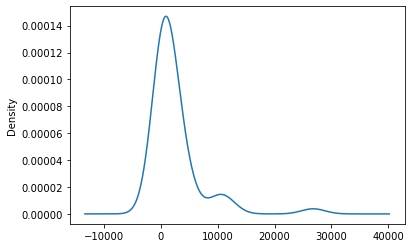

In [7]:
#check density to see where to bucket
states_counts.plot.density()

In [8]:
#let's try cutting off at 1,000 and call it "Other US States/Territories"
replacements = list(states_counts[states_counts < 1000].index)

# Replace in DataFrame
for state in replacements:
    fbi_df2.state_name = fbi_df2.state_name.replace(state,"Other_US_States/Territories")


# Check to make sure data succesfully binned
fbi_df2.state_name.value_counts()
#there must be something going on in North Carolina

North Carolina                 26784
Ohio                           11927
Massachusetts                  10788
Texas                          10233
Georgia                         9850
Tennessee                       4891
South Carolina                  4596
Other_US_States/Territories     4570
Virginia                        4468
Michigan                        3772
Alabama                         3393
West Virginia                   3383
Maryland                        2419
Nevada                          2308
Pennsylvania                    2263
Missouri                        2145
Indiana                         1581
New Mexico                      1518
Oregon                          1437
California                      1375
Washington                      1372
Colorado                        1367
New Jersey                      1359
Illinois                        1350
Arkansas                        1292
Florida                         1283
Mississippi                     1232
N

In [9]:
#let's check population codes now

pop_codes = fbi_df2.population_group_code.value_counts()
pop_codes
#not too many, but according to the term dictionary you cannot really bin these without losing meaning.
#would reccomend holding off on that unless the model is completely botched
#locations and property codes something similar. time to move on to data encoding

1B    14218
5     14145
4     14035
9A    13240
3     11067
6      8865
2      8845
1C     8096
9B     7977
1A     5865
8B     4895
8C     3849
7      3836
8D     1533
9C     1464
9D      983
8E       31
0         6
8A        4
9E        2
Name: population_group_code, dtype: int64

In [10]:
#make our target column binary for the encoder

fbi_df2.recovered_flag = fbi_df2.recovered_flag.replace({True:1,False:0})
#check to see if worked
fbi_df2.dtypes

agency_type_name          object
state_name                object
region_name               object
population_group_code     object
offense_code              object
offender_race             object
offender_ethnicity        object
offender_age             float64
offender_sex              object
victim_type_code          object
location_code              int64
weapon_code               object
prop_desc_code             int64
stolen_value             float64
recovered_flag             int64
dtype: object

In [11]:
#next up is to convert all of the object data into binary classifcations. The Datframe is going to become huge, but here we go.
object_columns = fbi_df2.dtypes[fbi_df2.dtypes == "object"].index.tolist()
print(object_columns)

['agency_type_name', 'state_name', 'region_name', 'population_group_code', 'offense_code', 'offender_race', 'offender_ethnicity', 'offender_sex', 'victim_type_code', 'weapon_code']


In [12]:
#Deploying the OHE produced earlier to make the conversions
# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(fbi_df2[object_columns]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names_out(object_columns)
encode_df.head()

,agency_type_name_City,agency_type_name_County,agency_type_name_Federal,agency_type_name_Other,agency_type_name_Other State Agency,agency_type_name_State Police,agency_type_name_Tribal,agency_type_name_University or College,state_name_Alabama,state_name_Arkansas,...,weapon_code_20,weapon_code_30,weapon_code_35,weapon_code_40,weapon_code_50,weapon_code_70,weapon_code_85,weapon_code_90,weapon_code_95,weapon_code_99
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [13]:
#take the encoded dataframe and add it back into the original, then drop the changed columns
fbi_df2 = fbi_df2.merge(encode_df, left_index=True, right_index = True)
fbi_df2= fbi_df2.drop(labels =object_columns,axis=1)
fbi_df2.head()

,offender_age,location_code,prop_desc_code,stolen_value,recovered_flag,agency_type_name_City,agency_type_name_County,agency_type_name_Federal,agency_type_name_Other,agency_type_name_Other State Agency,...,weapon_code_20,weapon_code_30,weapon_code_35,weapon_code_40,weapon_code_50,weapon_code_70,weapon_code_85,weapon_code_90,weapon_code_95,weapon_code_99
0,0.0,25,20,375.0,0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,20,77,1.0,0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,20,65,0.0,0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,20,13,320.0,0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,20,77,1.0,0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [14]:
#did it work? Yes!
print(fbi_df2.dtypes.value_counts())

float64    122
int64        3
dtype: int64


In [15]:
#export this CSV for group and to save time in future
fbi_df2.to_csv("FBI_csv_object_encoded.csv", index=False)

In [16]:
#SPLIT THE DATA FOR TESTING AND TRAINING
y = fbi_df2["recovered_flag"].values
X = fbi_df2.drop(labels ="recovered_flag",axis =1).values
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=78)

In [17]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [18]:
# Define the model, crazy complex data so will do many layers and many nuerons #1st attempt, 3 layers, 7,6,6. 
number_input_features = len(X_train[0])
hidden_nodes_layer1 = 7
hidden_nodes_layer2 = 6
hidden_nodes_layer3 = 6
nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features,activation="relu"))
       
# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2 ,activation="relu"))

#Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="relu"))
# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

2023-02-16 21:18:46.267109: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 7)                 875       
                                                                 
 dense_1 (Dense)             (None, 6)                 48        
                                                                 
 dense_2 (Dense)             (None, 6)                 42        
                                                                 
 dense_3 (Dense)             (None, 1)                 7         
                                                                 
Total params: 972
Trainable params: 972
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [20]:
#send it
fit_model = nn.fit(X_train,y_train,epochs=100)

Epoch 1/100
2882/2882 [==============================] - 7s 2ms/step - loss: 4.6353 - accuracy: 0.8344
Epoch 2/100
2882/2882 [==============================] - 6s 2ms/step - loss: 1.4106 - accuracy: 0.8523
Epoch 3/100
2882/2882 [==============================] - 6s 2ms/step - loss: 1.5935 - accuracy: 0.8589
Epoch 4/100
2882/2882 [==============================] - 8s 3ms/step - loss: 0.4322 - accuracy: 0.8479
Epoch 5/100
2882/2882 [==============================] - 6s 2ms/step - loss: 0.3581 - accuracy: 0.8486
Epoch 6/100
2882/2882 [==============================] - 6s 2ms/step - loss: 0.3483 - accuracy: 0.8593
Epoch 7/100
2882/2882 [==============================] - 6s 2ms/step - loss: 0.3454 - accuracy: 0.8593
Epoch 8/100
2882/2882 [==============================] - 6s 2ms/step - loss: 0.3423 - accuracy: 0.8593
Epoch 9/100
2882/2882 [==============================] - 5s 2ms/step - loss: 0.3498 - accuracy: 0.8593
Epoch 10/100
2882/2882 [==============================] - 6s 2ms/step - l

2882/2882 [==============================] - 5s 2ms/step - loss: 0.3303 - accuracy: 0.8593
Epoch 80/100
2882/2882 [==============================] - 5s 2ms/step - loss: 0.3321 - accuracy: 0.8593
Epoch 81/100
2882/2882 [==============================] - 5s 2ms/step - loss: 0.3305 - accuracy: 0.8593
Epoch 82/100
2882/2882 [==============================] - 5s 2ms/step - loss: 0.3367 - accuracy: 0.8593
Epoch 83/100
2882/2882 [==============================] - 6s 2ms/step - loss: 0.3297 - accuracy: 0.8593
Epoch 84/100
2882/2882 [==============================] - 5s 2ms/step - loss: 0.3311 - accuracy: 0.8593
Epoch 85/100
2882/2882 [==============================] - 5s 2ms/step - loss: 0.3306 - accuracy: 0.8593
Epoch 86/100
2882/2882 [==============================] - 6s 2ms/step - loss: 0.3327 - accuracy: 0.8593
Epoch 87/100
2882/2882 [==============================] - 6s 2ms/step - loss: 0.3332 - accuracy: 0.8593
Epoch 88/100
2882/2882 [==============================] - 5s 2ms/step - loss:

In [21]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

961/961 - 1s - loss: 0.3894 - accuracy: 0.8600 - 1s/epoch - 1ms/step
Loss: 0.38935256004333496, Accuracy: 0.8600475192070007


In [22]:
#export current model to HDF5 File
nn.save("NN_model_1.h5")

In [23]:
#ten percent difference inbetween training and testing accuracy.
#maybe model too big. making smaller model
# Define the model, crazy complex data so will do many layers and many nuerons #1st attempt, 3 layers, 7,6,6. 
number_input_features = len(X_train[0])
hidden_nodes2_layer1 = 5
hidden_nodes2_layer2 = 5
nn2 = tf.keras.models.Sequential()

# First hidden layer
nn2.add(tf.keras.layers.Dense(units=hidden_nodes2_layer1, input_dim=number_input_features,activation="relu"))
       
# Second hidden layer
nn2.add(tf.keras.layers.Dense(units=hidden_nodes2_layer2 ,activation="relu"))

# Output layer
nn2.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 5)                 625       
                                                                 
 dense_5 (Dense)             (None, 5)                 30        
                                                                 
 dense_6 (Dense)             (None, 1)                 6         
                                                                 
Total params: 661
Trainable params: 661
Non-trainable params: 0
_________________________________________________________________


In [24]:
# Compile the second model
nn2.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [25]:
#send it 2
fit_model2 = nn2.fit(X_train,y_train,epochs=100)

Epoch 1/100
2882/2882 [==============================] - 7s 2ms/step - loss: 1.7670 - accuracy: 0.8574
Epoch 2/100
2882/2882 [==============================] - 5s 2ms/step - loss: 0.3681 - accuracy: 0.8598
Epoch 3/100
2882/2882 [==============================] - 5s 2ms/step - loss: 0.3693 - accuracy: 0.8602
Epoch 4/100
2882/2882 [==============================] - 5s 2ms/step - loss: 0.3548 - accuracy: 0.8604
Epoch 5/100
2882/2882 [==============================] - 5s 2ms/step - loss: 0.3563 - accuracy: 0.8605
Epoch 6/100
2882/2882 [==============================] - 5s 2ms/step - loss: 0.3500 - accuracy: 0.8606
Epoch 7/100
2882/2882 [==============================] - 5s 2ms/step - loss: 0.3465 - accuracy: 0.8607
Epoch 8/100
2882/2882 [==============================] - 5s 2ms/step - loss: 0.3496 - accuracy: 0.8607
Epoch 9/100
2882/2882 [==============================] - 5s 2ms/step - loss: 0.3450 - accuracy: 0.8608
Epoch 10/100
2882/2882 [==============================] - 5s 2ms/step - l

2882/2882 [==============================] - 5s 2ms/step - loss: 0.3330 - accuracy: 0.8610
Epoch 80/100
2882/2882 [==============================] - 5s 2ms/step - loss: 0.3342 - accuracy: 0.8611
Epoch 81/100
2882/2882 [==============================] - 5s 2ms/step - loss: 0.3293 - accuracy: 0.8610
Epoch 82/100
2882/2882 [==============================] - 5s 2ms/step - loss: 0.3353 - accuracy: 0.8611
Epoch 83/100
2882/2882 [==============================] - 5s 2ms/step - loss: 0.3278 - accuracy: 0.8611
Epoch 84/100
2882/2882 [==============================] - 6s 2ms/step - loss: 0.3313 - accuracy: 0.8611
Epoch 85/100
2882/2882 [==============================] - 6s 2ms/step - loss: 0.3341 - accuracy: 0.8610
Epoch 86/100
2882/2882 [==============================] - 6s 2ms/step - loss: 0.3317 - accuracy: 0.8609
Epoch 87/100
2882/2882 [==============================] - 6s 2ms/step - loss: 0.3365 - accuracy: 0.8611
Epoch 88/100
2882/2882 [==============================] - 5s 2ms/step - loss:

In [26]:
# Evaluate the model using the test data
model_loss2, model_accuracy2 = nn2.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss2}, Accuracy: {model_accuracy2}")

961/961 - 1s - loss: 2.2200 - accuracy: 0.5559 - 1s/epoch - 1ms/step
Loss: 2.21999192237854, Accuracy: 0.5559061765670776


In [27]:
#export second model to HDF5 File
nn2.save("NN_model_2.h5")